In [2]:
import os
import shutil
import enjoyml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from skimage.io import imread, imsave
from skimage.transform import resize
import matplotlib.pyplot as plt
# from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.decomposition import PCA
# from joblib import dump, load

# from data_engineering import read_data, get_filter_duplicates_query

In [4]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras import backend as K

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
set_session(tf.Session(config=config))
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [5]:
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, Input, Dense, Dropout, Flatten, GlobalMaxPool2D
from keras.applications.resnet_v2 import ResNet50V2
from keras.optimizers import Adam
from enjoyml.keras.layers import FixedPooling2D

In [6]:
from keras import layers, models, optimizers, callbacks, regularizers

### Загрузка данных

In [7]:
TRAIN_DATA_PATH = 'data/sign_mnist_train.csv'
TEST_DATA_PATH = 'data/sign_mnist_test.csv'

df_train = pd.read_csv(TRAIN_DATA_PATH)
df_test = pd.read_csv(TEST_DATA_PATH)

In [8]:
def get_data(df, img_size=28):
    return df.iloc[:, 1:].values.reshape((df.shape[0], img_size, img_size, 1)), df['label'].values

work_images, work_labels = get_data(df_train)
test_images, test_labels = get_data(df_test)

print(work_images.shape, test_images.shape)

(27455, 28, 28, 1) (7172, 28, 28, 1)


In [9]:
np.unique(work_labels), np.unique(work_labels).shape

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24]),
 (24,))

In [10]:
train_indixes, val_indexes = train_test_split(np.arange(work_images.shape[0]), 
                                              test_size=0.1, stratify=work_labels, random_state=42)

print(train_indixes.shape, val_indexes.shape)
train_images, train_labels = work_images[train_indixes], work_labels[train_indixes]
val_images, val_labels = work_images[val_indexes], work_labels[val_indexes]

(24709,) (2746,)


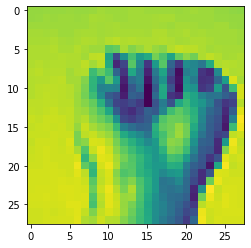

In [13]:
plt.imshow(train_images[0].reshape((28, 28)))

### Кастомная сверточная сеть, без аугментации

In [26]:
IMG_SIZE = 28#150
VALIDATION_SPLIT = 0.1
TRAIN_BATCH_SIZE = 256
VAL_BATCH_SIZE = 48
N_EPOCHS = 150

IMAGES_TOTAL_COUNT = 25000

In [27]:
def get_model():
    input_ = x = Input((IMG_SIZE, IMG_SIZE, 1))
    
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = MaxPool2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPool2D((2, 2))(x)
    
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPool2D((2, 2))(x)
    
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = MaxPool2D((2, 2))(x)
    
    x = Flatten()(x)

    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(25, activation='softmax')(x)

    return Model(inputs=input_, outputs=output)

model = get_model()
model.compile('Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 7, 64)          0   

In [28]:
from enjoyml.multiclass import calc_class_weights
from keras.preprocessing.image import ImageDataGenerator


data_gen_args = dict(
    rescale=1/255.,
)

datagen = ImageDataGenerator(**data_gen_args)

In [29]:
lr_reducer = callbacks.ReduceLROnPlateau(monitor='loss', factor=5e-2, patience=3, 
                                         min_lr=1e-15, min_delta=0.01, verbose=1)
stopper = callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=5, 
                                  verbose=1#, restore_best_weights=True
                                 )
stopper_val = callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10, 
                                  verbose=1#, restore_best_weights=True
                                     )

In [30]:
TRAIN_STEPS_PER_EPOCH = int(IMAGES_TOTAL_COUNT * (1 - VALIDATION_SPLIT)/TRAIN_BATCH_SIZE) + 1
VAL_STEPS_PER_EPOCH = int(IMAGES_TOTAL_COUNT * VALIDATION_SPLIT/VAL_BATCH_SIZE) + 1

model.fit_generator(
    datagen.flow(
        train_images, train_labels,
        batch_size=TRAIN_BATCH_SIZE,
        shuffle=True,
    ),
    steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
    epochs=N_EPOCHS,
    class_weight=calc_class_weights(train_labels),
    validation_data=datagen.flow(
        val_images, val_labels,
        batch_size=VAL_BATCH_SIZE,
        shuffle=True,
    ),
    callbacks=[lr_reducer, stopper, stopper_val], 
    validation_steps=VAL_STEPS_PER_EPOCH,
)

Epoch 1/150
88/88 [==============================] - 3s 30ms/step - loss: 3.5174 - accuracy: 0.0619 - val_loss: 2.6352 - val_accuracy: 0.2052
Epoch 2/150
88/88 [==============================] - 2s 28ms/step - loss: 1.7579 - accuracy: 0.4693 - val_loss: 0.3757 - val_accuracy: 0.8236
Epoch 3/150
88/88 [==============================] - 2s 26ms/step - loss: 0.4346 - accuracy: 0.8635 - val_loss: 0.2053 - val_accuracy: 0.9350
Epoch 4/150
88/88 [==============================] - 2s 28ms/step - loss: 0.1344 - accuracy: 0.9590 - val_loss: 0.0030 - val_accuracy: 0.9968
Epoch 5/150
88/88 [==============================] - 2s 28ms/step - loss: 0.0486 - accuracy: 0.9865 - val_loss: 0.0012 - val_accuracy: 0.9996
Epoch 6/150
88/88 [==============================] - 2s 28ms/step - loss: 0.0291 - accuracy: 0.9927 - val_loss: 0.0038 - val_accuracy: 0.9988
Epoch 7/150
88/88 [==============================] - 2s 28ms/step - loss: 0.0299 - accuracy: 0.9925 - val_loss: 9.6677e-05 - val_accuracy: 0.9996
Ep

In [32]:
model.evaluate(test_images/255, test_labels)

7172/7172 [==============================] - 1s 80us/step


[0.14894315590616847, 0.9610987305641174]

### Кастомная сверточная сеть, с аугментацией

In [39]:
IMG_SIZE = 28#150
VALIDATION_SPLIT = 0.1
TRAIN_BATCH_SIZE = 256
VAL_BATCH_SIZE = 48
N_EPOCHS = 150

In [40]:
def get_model():
    input_ = x = Input((IMG_SIZE, IMG_SIZE, 1))
    
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = MaxPool2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPool2D((2, 2))(x)
    
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPool2D((2, 2))(x)
    
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = MaxPool2D((2, 2))(x)
    
    x = Flatten()(x)

    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(25, activation='softmax')(x)

    return Model(inputs=input_, outputs=output)

model = get_model()
model.compile('Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 7, 7, 64)          0   

In [41]:
from enjoyml.multiclass import calc_class_weights
from keras.preprocessing.image import ImageDataGenerator


data_gen_args = dict(
    rescale=1/255.,
    rotation_range=0.02,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=[0.95, 1.05],
#     horizontal_flip=True,
#     vertical_flip=True,
    fill_mode='reflect',
)

datagen = ImageDataGenerator(**data_gen_args)

lr_reducer = callbacks.ReduceLROnPlateau(monitor='loss', factor=5e-2, patience=3, 
                                         min_lr=1e-15, min_delta=0.001, verbose=1)
stopper = callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=10, 
                                  verbose=1#, restore_best_weights=True
                                 )
stopper_val = callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10, 
                                  verbose=1#, restore_best_weights=True
                                     )

In [42]:
TRAIN_STEPS_PER_EPOCH = int(train_images.shape[0]/TRAIN_BATCH_SIZE) + 1
VAL_STEPS_PER_EPOCH = int(val_images.shape[0]/VAL_BATCH_SIZE) + 1

model.fit_generator(
    datagen.flow(
        train_images, train_labels,
        batch_size=TRAIN_BATCH_SIZE,
        shuffle=True,
    ),
    steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
    epochs=N_EPOCHS,
    class_weight=calc_class_weights(train_labels),
    validation_data=datagen.flow(
        val_images, val_labels,
        batch_size=VAL_BATCH_SIZE,
        shuffle=True,
    ),
    callbacks=[lr_reducer, stopper, stopper_val], 
    validation_steps=VAL_STEPS_PER_EPOCH,
)

Epoch 1/150
88/88 [==============================] - 5s 53ms/step - loss: 3.6227 - accuracy: 0.0394 - val_loss: 3.1913 - val_accuracy: 0.0425
Epoch 2/150
88/88 [==============================] - 5s 53ms/step - loss: 3.5929 - accuracy: 0.0463 - val_loss: 3.0197 - val_accuracy: 0.0930
Epoch 3/150
88/88 [==============================] - 4s 50ms/step - loss: 2.8486 - accuracy: 0.1934 - val_loss: 1.6826 - val_accuracy: 0.4182
Epoch 4/150
88/88 [==============================] - 4s 49ms/step - loss: 1.5033 - accuracy: 0.5175 - val_loss: 0.5609 - val_accuracy: 0.7538
Epoch 5/150
88/88 [==============================] - 4s 50ms/step - loss: 0.5831 - accuracy: 0.8083 - val_loss: 0.1470 - val_accuracy: 0.9186
Epoch 6/150
88/88 [==============================] - 4s 51ms/step - loss: 0.2293 - accuracy: 0.9313 - val_loss: 0.1694 - val_accuracy: 0.9501
Epoch 7/150
88/88 [==============================] - 4s 50ms/step - loss: 0.1176 - accuracy: 0.9661 - val_loss: 0.0251 - val_accuracy: 0.9912
Epoch 

In [43]:
model.evaluate(test_images/255, test_labels)

7172/7172 [==============================] - 1s 80us/step


[0.00062408311848169, 0.9998605847358704]

### Дообучение resnet сеть, с аугментацией

In [16]:
IMG_SIZE = 28#150
VALIDATION_SPLIT = 0.1
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 64
N_EPOCHS = 250

In [17]:
gray_imgs_to_rgbs = lambda gray_imgs: np.repeat(gray_imgs, 3, -1)
train_images_rgb = gray_imgs_to_rgbs(train_images)
val_images_rgb = gray_imgs_to_rgbs(val_images)
test_images_rgb = gray_imgs_to_rgbs(test_images)

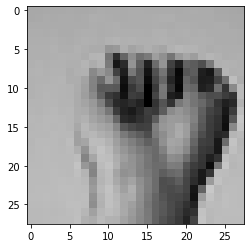

In [18]:
plt.imshow(train_images_rgb[0])

In [20]:
IMAGE_NET = True

resnet_conv_base = ResNet50V2(
    include_top=False, 
    weights='imagenet' if IMAGE_NET else None, 
    input_shape=(32, 32, 3)
)  # imagenet


def get_resnet_model():
    input_ = Input((IMG_SIZE, IMG_SIZE, 3))
    
    x = resnet_conv_base(input_)

    x = Flatten()(x)
#     x = GlobalMaxPool2D()(x)

    x = Dropout(0.3)(x)
#     x = Dense(2048, activation='relu')(x)
#     x = Dropout(0.35)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(25, activation='softmax')(x)

    model = Model(inputs=input_, outputs=output)
    
#     for layer in model.layers[1].layers[:-22]:
    for layer in model.layers[1].layers[:-42]:
        layer.trainable = False
    
    return model

resnet_model = get_resnet_model()
if IMAGE_NET:
    #sparse_categorical_crossentropy
    resnet_model.compile(Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
else:
    resnet_model.compile('Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
resnet_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 3)         0         
_________________________________________________________________
resnet50v2 (Model)           (None, 1, 1, 2048)        23564800  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2624

In [22]:
from enjoyml.multiclass import calc_class_weights
from keras.preprocessing.image import ImageDataGenerator


data_gen_args = dict(
    rescale=1/255.,
    rotation_range=0.02,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=[0.95, 1.05],
#     horizontal_flip=True,
#     vertical_flip=True,
    fill_mode='reflect',
)

datagen = ImageDataGenerator(**data_gen_args)

lr_reducer = callbacks.ReduceLROnPlateau(monitor='loss', factor=5e-2, patience=3, 
                                         min_lr=1e-15, min_delta=0.001, verbose=1)
stopper = callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=10, 
                                  verbose=1#, restore_best_weights=True
                                 )
stopper_val = callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10, 
                                  verbose=1#, restore_best_weights=True
                                     )

In [23]:
TRAIN_STEPS_PER_EPOCH = int(train_images.shape[0]/TRAIN_BATCH_SIZE) + 1
VAL_STEPS_PER_EPOCH = int(val_images.shape[0]/VAL_BATCH_SIZE) + 1

resnet_model.fit_generator(
    datagen.flow(
        train_images_rgb, train_labels,
        batch_size=TRAIN_BATCH_SIZE,
        shuffle=True,
    ),
    steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
    epochs=N_EPOCHS,
    class_weight=calc_class_weights(train_labels),
    validation_data=datagen.flow(
        val_images_rgb, val_labels,
        batch_size=VAL_BATCH_SIZE,
        shuffle=True,
    ),
    callbacks=[lr_reducer, stopper, stopper_val], 
    validation_steps=VAL_STEPS_PER_EPOCH,
)

Epoch 1/250
194/194 [==============================] - 12s 63ms/step - loss: 3.3684 - accuracy: 0.1555 - val_loss: 3.0121 - val_accuracy: 0.2225
Epoch 2/250
194/194 [==============================] - 10s 49ms/step - loss: 1.9051 - accuracy: 0.5109 - val_loss: 1.5141 - val_accuracy: 0.4982
Epoch 3/250
194/194 [==============================] - 10s 49ms/step - loss: 1.0778 - accuracy: 0.7087 - val_loss: 1.0777 - val_accuracy: 0.6162
Epoch 4/250
194/194 [==============================] - 10s 50ms/step - loss: 0.7429 - accuracy: 0.7986 - val_loss: 0.7511 - val_accuracy: 0.7604
Epoch 5/250
194/194 [==============================] - 10s 50ms/step - loss: 0.5718 - accuracy: 0.8454 - val_loss: 0.3871 - val_accuracy: 0.8740
Epoch 6/250
194/194 [==============================] - 10s 50ms/step - loss: 0.4684 - accuracy: 0.8709 - val_loss: 0.2228 - val_accuracy: 0.9275
Epoch 7/250
194/194 [==============================] - 10s 50ms/step - loss: 0.4082 - accuracy: 0.8911 - val_loss: 0.1399 - val_ac

In [24]:
resnet_model.evaluate(test_images_rgb/255, test_labels)

7172/7172 [==============================] - 3s 384us/step


[0.17711056930343352, 0.959286093711853]

### Общее сравнение

In [32]:
model.evaluate(test_images/255, test_labels)

7172/7172 [==============================] - 1s 80us/step


[0.14894315590616847, 0.9610987305641174]

In [43]:
model.evaluate(test_images/255, test_labels)

7172/7172 [==============================] - 1s 80us/step


[0.00062408311848169, 0.9998605847358704]

In [24]:
resnet_model.evaluate(test_images_rgb/255, test_labels)

7172/7172 [==============================] - 3s 384us/step


[0.17711056930343352, 0.959286093711853]